<a href="https://colab.research.google.com/github/SebaAyala/AST_TP_2/blob/main/AST_TP_2_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

from google.colab import drive
from google.colab import auth
from google.auth import default

In [3]:
creds, _ = default()
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

Mounted at /content/drive


## Carga de datasets

In [47]:
# Ruta al archivo en tu Google Drive
df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
df_precipitaciones = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/precip.xlsx', skiprows=3)
df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])

/tmp/ipython-input-633792332.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
/tmp/ipython-input-633792332.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])


In [48]:
print(df_siniestros.head())
print(df_precipitaciones.head())
print(df_temperatura.head())

          id_hecho  n_victimas       fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2  2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1  2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1  2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2  2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1  2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_d

In [49]:
lista_datasets = [df_siniestros, df_precipitaciones, df_temperatura]
for i in lista_datasets:
  print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44012 entries, 0 to 44011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_hecho               44012 non-null  object
 1   n_victimas             44012 non-null  int64 
 2   fecha                  44012 non-null  object
 3   aaaa                   44012 non-null  int64 
 4   mm                     44012 non-null  int64 
 5   dd                     44012 non-null  int64 
 6   hora                   44012 non-null  object
 7   hh                     44012 non-null  object
 8   direccion_normalizada  44012 non-null  object
 9   calle                  33111 non-null  object
 10  altura                 32665 non-null  object
 11  cruce                  29509 non-null  object
 12  otra_direccion         44012 non-null  object
 13  comuna                 44012 non-null  object
 14  tipo_de_calle          44012 non-null  object
 15  geocodificacion_cab

# Siniestros

In [50]:
df_siniestros['fecha'] = pd.to_datetime(df_siniestros['fecha'],  errors='coerce')
df_siniestros.head()

,id_hecho,n_victimas,fecha,aaaa,mm,dd,hora,hh,direccion_normalizada,calle,...,comuna,tipo_de_calle,geocodificacion_caba,longitud,latitud,participantes,victima,contraparte,gravedad,tipo_de_dato
0,LC-2019-0008283,2,2019-01-04,2019,1,4,17:53:00,17,SD,NaN,...,SD,SD,SD,SD,SD,AUTO-SD,AUTO,SD,SD,definitivo
1,LC-2019-0007634,1,2019-01-04,2019,1,4,14:50:00,14,SD,NaN,...,SD,SD,SD,SD,SD,MOTO-SD,MOTO,SD,SD,definitivo
2,LC-2019-0008974,1,2019-01-05,2019,1,5,09:30:00,9,SD,NaN,...,SD,SD,SD,SD,SD,BICICLETA-SD,BICICLETA,SD,SD,definitivo
3,LC-2019-0010983,2,2019-01-06,2019,1,6,22:20:00,22,SD,NaN,...,SD,SD,SD,SD,SD,AUTO-SD,AUTO,SD,SD,definitivo
4,LC-2019-0011092,1,2019-01-07,2019,1,7,03:50:00,3,SD,NaN,...,SD,SD,SD,SD,SD,PEATON-SD,PEATON,SD,SD,definitivo


In [51]:
df_siniestros = df_siniestros.groupby('fecha').size().reset_index(name='cantidad_eventos')
# df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

,fecha,cantidad_eventos
0,2019-01-01,18
1,2019-01-02,16
2,2019-01-03,24
3,2019-01-04,35
4,2019-01-05,19


In [53]:
df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

,cantidad_eventos
fecha,
2019-01-01,18
2019-01-02,16
2019-01-03,24
2019-01-04,35
2019-01-05,19


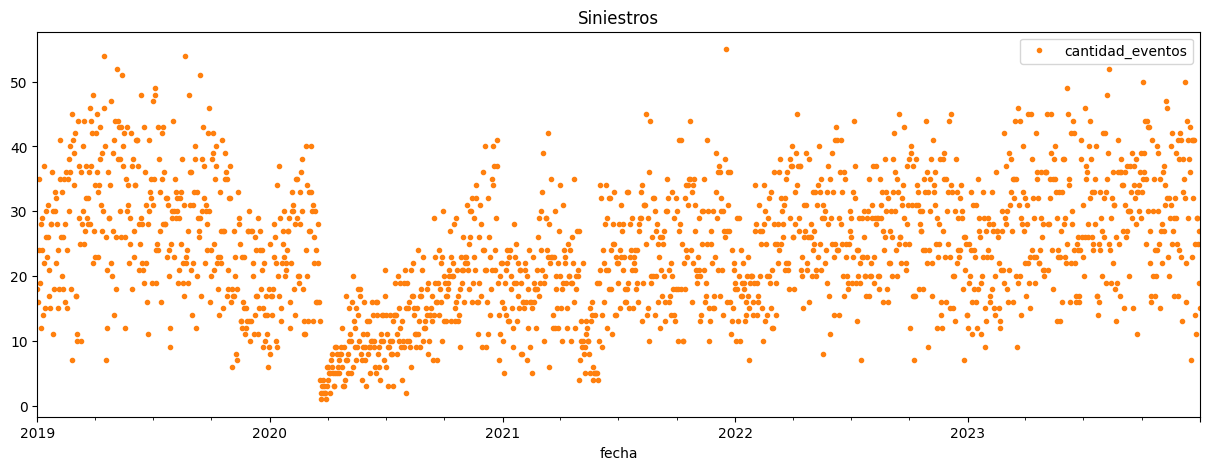

In [54]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

In [55]:
print('Cantidad de NaNs:')
for column in df_siniestros:
    nans = df_siniestros[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna cantidad_eventos: 0


Analisis de outliers

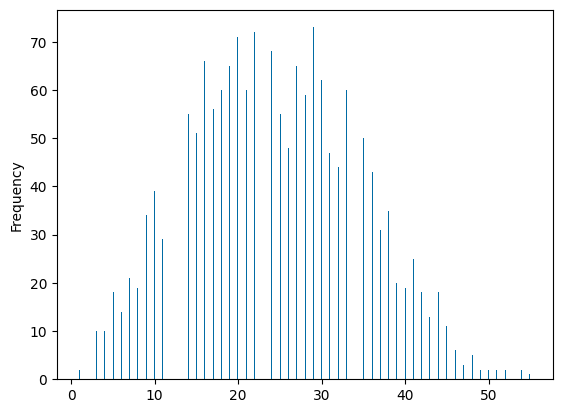

In [57]:
df_siniestros['cantidad_eventos'].plot(kind='hist', bins=500);

Outliers based on IQR:


,cantidad_eventos
fecha,
2019-04-16,54
2019-08-21,54
2021-12-17,55


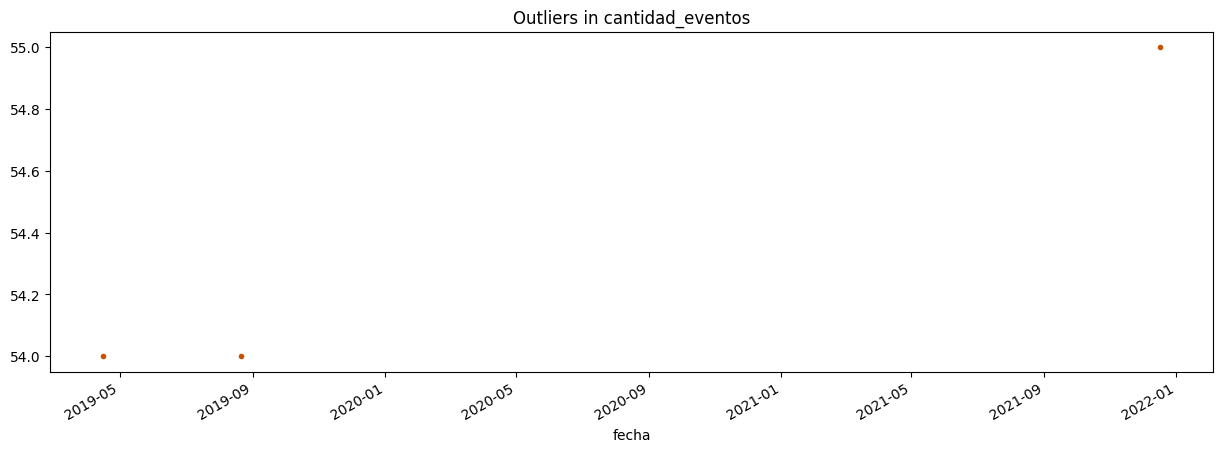

In [58]:
Q1 = df_siniestros['cantidad_eventos'].quantile(0.25)
Q3 = df_siniestros['cantidad_eventos'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_siniestros[(df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['cantidad_eventos'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in cantidad_eventos')
plt.show()

In [59]:
#Lo que hago es modificar los outliers por el valor 53, que es el valor menor a que se considere outlier
condicion = (df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)
df_siniestros.loc[condicion, 'cantidad_eventos'] = 53

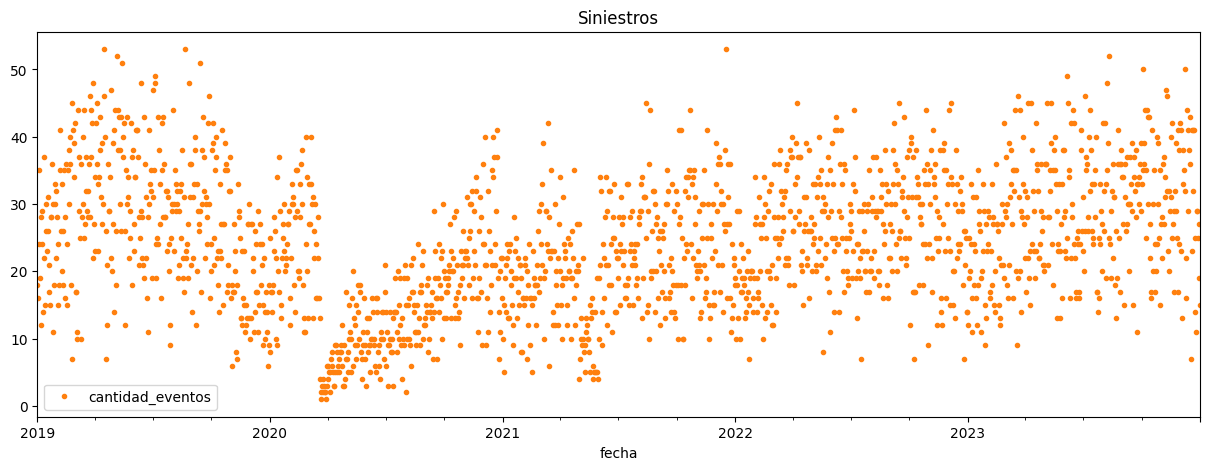

In [60]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

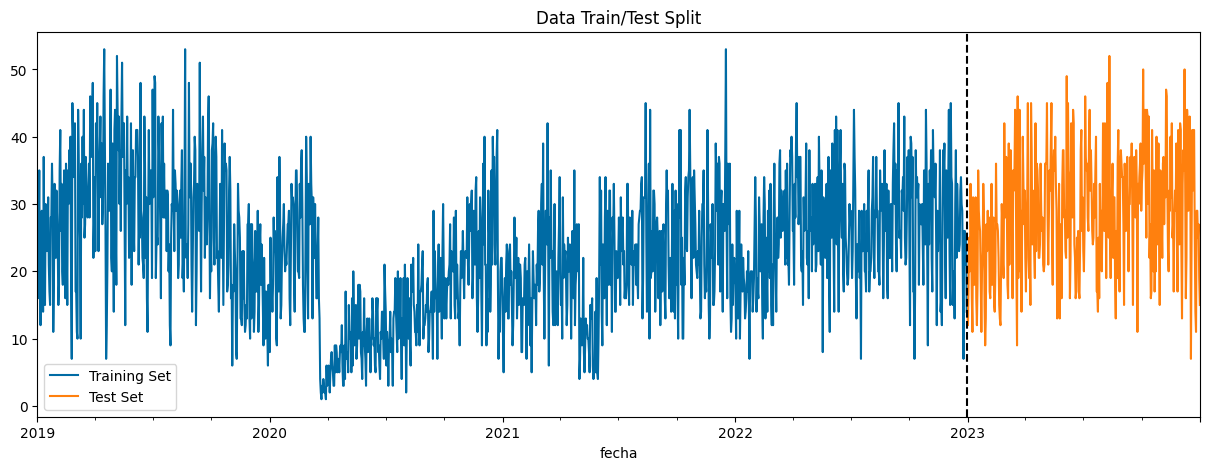

In [61]:
split_index = int(len(df_siniestros) * 0.8)
train_siniestros = df_siniestros.iloc[:split_index]
test_siniestros = df_siniestros.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_siniestros.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_siniestros.plot(ax=ax, label='Test Set')
ax.axvline(test_siniestros.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.
n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [104]:
tss_siniestros = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_siniestros_cv = df_siniestros.sort_index()

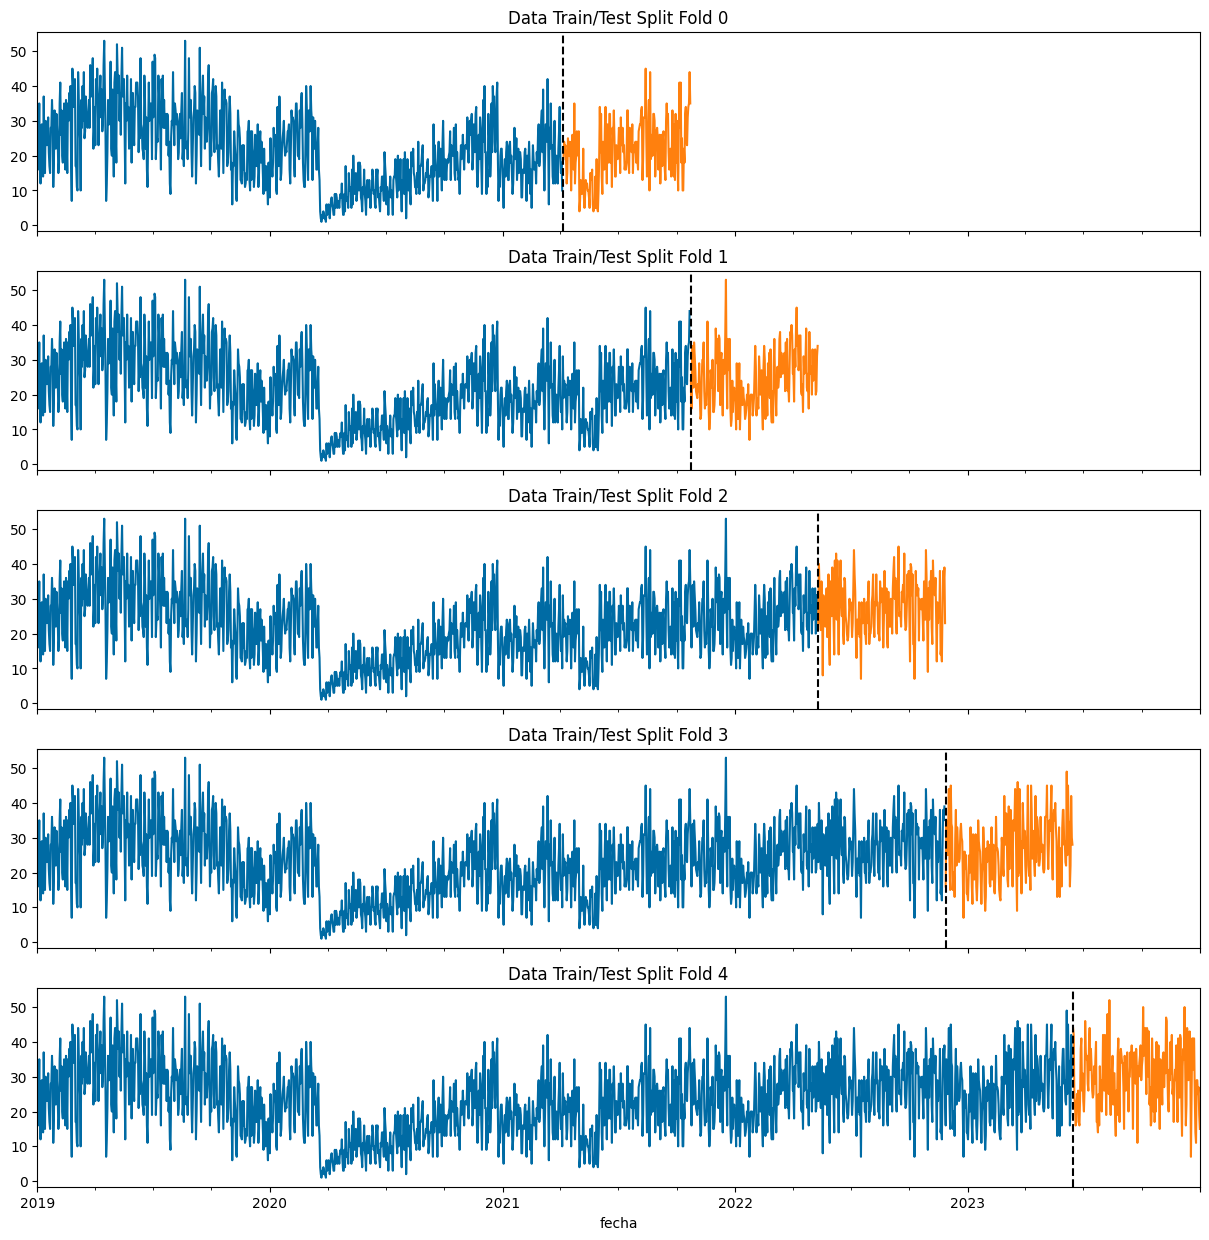

In [105]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_siniestros.split(df_siniestros_cv):
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]
    train['cantidad_eventos'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['cantidad_eventos'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [106]:
tss_siniestros

TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=200)

In [107]:
for i, (train_index, test_index) in enumerate(tss_siniestros.split(df_siniestros_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [108]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [109]:
df_siniestros_cv = create_features(df_siniestros_cv)

In [110]:
def add_lags(df):
    target_map = df['cantidad_eventos'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [111]:
df_siniestros_cv = add_lags(df_siniestros_cv)

In [112]:
df_siniestros_cv.head(3)

,cantidad_eventos,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
fecha,,,,,,,,,,,,
2019-01-01,18,0,1,1,1,2019,1,1,1,NaN,NaN,NaN
2019-01-02,16,0,2,1,1,2019,2,2,1,NaN,NaN,NaN
2019-01-03,24,0,3,1,1,2019,3,3,1,NaN,NaN,NaN


In [113]:
tss_siniestros_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_siniestros_cv = df_siniestros_cv.sort_index()

In [114]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_siniestros_2.split(df_siniestros_cv): #Iterar sobre las particiones
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = 'cantidad_eventos'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10.72343	validation_0-mae:8.78479	validation_1-rmse:8.66924	validation_1-mae:7.04428


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:26] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:7.57678	validation_0-mae:5.99368	validation_1-rmse:9.14662	validation_1-mae:7.39160
[200]	validation_0-rmse:6.72825	validation_0-mae:5.19142	validation_1-rmse:9.05097	validation_1-mae:7.31285
[300]	validation_0-rmse:6.41834	validation_0-mae:4.90523	validation_1-rmse:9.00338	validation_1-mae:7.30798
[400]	validation_0-rmse:6.24619	validation_0-mae:4.75674	validation_1-rmse:8.97475	validation_1-mae:7.29652
[500]	validation_0-rmse:6.10861	validation_0-mae:4.63473	validation_1-rmse:8.74947	validation_1-mae:7.10669
[600]	validation_0-rmse:6.02094	validation_0-mae:4.55279	validation_1-rmse:8.83730	validation_1-mae:7.16783
[700]	validation_0-rmse:5.91563	validation_0-mae:4.45985	validation_1-rmse:8.87836	validation_1-mae:7.19299
[800]	validation_0-rmse:5.80611	validation_0-mae:4.36608	validation_1-rmse:8.91354	validation_1-mae:7.22781
[900]	validation_0-rmse:5.68267	validation_0-mae:4.27318	validation_1-rmse:8.97586	validation_1-mae:7.28724
[999]	validation_0-rmse:5.59

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:6.74105	validation_0-mae:5.27219	validation_1-rmse:9.35887	validation_1-mae:7.28239
[400]	validation_0-rmse:6.52105	validation_0-mae:5.07266	validation_1-rmse:9.39088	validation_1-mae:7.29461
[500]	validation_0-rmse:6.32318	validation_0-mae:4.89201	validation_1-rmse:9.48240	validation_1-mae:7.39223
[600]	validation_0-rmse:6.14601	validation_0-mae:4.72694	validation_1-rmse:9.66918	validation_1-mae:7.51475
[700]	validation_0-rmse:6.02110	validation_0-mae:4.61008	validation_1-rmse:9.78675	validation_1-mae:7.59725
[800]	validation_0-rmse:5.94560	validation_0-mae:4.53288	validation_1-rmse:9.80923	validation_1-mae:7.62253
[900]	validation_0-rmse:5.85959	validation_0-mae:4.45284	validation_1-rmse:9.86440	validation_1-mae:7.66929
[999]	validation_0-rmse:5.71632	validation_0-mae:4.34000	validation_1-rmse:9.97722	validation_1-mae:7.74403
[0]	validation_0-rmse:10.07582	validation_0-mae:8.21304	validation_1-rmse:9.47461	validation_1-mae:7.70149
[100]	validation_0-rmse:8.050

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:29] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:7.08429	validation_0-mae:5.58269	validation_1-rmse:7.95991	validation_1-mae:6.38534
[400]	validation_0-rmse:6.87144	validation_0-mae:5.39588	validation_1-rmse:7.91861	validation_1-mae:6.34754
[500]	validation_0-rmse:6.68182	validation_0-mae:5.22444	validation_1-rmse:7.82485	validation_1-mae:6.26247
[600]	validation_0-rmse:6.48183	validation_0-mae:5.04171	validation_1-rmse:7.59869	validation_1-mae:6.05357
[700]	validation_0-rmse:6.35306	validation_0-mae:4.92639	validation_1-rmse:7.48410	validation_1-mae:5.97321
[800]	validation_0-rmse:6.27140	validation_0-mae:4.85454	validation_1-rmse:7.44397	validation_1-mae:5.94250
[900]	validation_0-rmse:6.16786	validation_0-mae:4.76341	validation_1-rmse:7.28814	validation_1-mae:5.81645
[999]	validation_0-rmse:6.09868	validation_0-mae:4.70181	validation_1-rmse:7.24666	validation_1-mae:5.78655
[0]	validation_0-rmse:9.97200	validation_0-mae:8.16220	validation_1-rmse:9.58734	validation_1-mae:7.67605
[100]	validation_0-rmse:8.0749

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:30] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.75974	validation_0-mae:5.30415	validation_1-rmse:9.11147	validation_1-mae:6.87551
[500]	validation_0-rmse:6.56341	validation_0-mae:5.13271	validation_1-rmse:9.14884	validation_1-mae:6.81789
[600]	validation_0-rmse:6.38814	validation_0-mae:4.97675	validation_1-rmse:9.25728	validation_1-mae:6.85662
[700]	validation_0-rmse:6.25628	validation_0-mae:4.85784	validation_1-rmse:9.32409	validation_1-mae:6.87541
[800]	validation_0-rmse:6.15370	validation_0-mae:4.76473	validation_1-rmse:9.38678	validation_1-mae:6.90074
[900]	validation_0-rmse:6.05404	validation_0-mae:4.67988	validation_1-rmse:9.68918	validation_1-mae:7.11696
[999]	validation_0-rmse:5.95695	validation_0-mae:4.60048	validation_1-rmse:9.96825	validation_1-mae:7.32604
[0]	validation_0-rmse:9.91304	validation_0-mae:8.11711	validation_1-rmse:11.21255	validation_1-mae:9.25115
[100]	validation_0-rmse:8.02248	validation_0-mae:6.42303	validation_1-rmse:9.40692	validation_1-mae:7.67271
[200]	validation_0-rmse:7.459

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:30] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.87698	validation_0-mae:5.38974	validation_1-rmse:7.88500	validation_1-mae:6.32446
[500]	validation_0-rmse:6.68704	validation_0-mae:5.22861	validation_1-rmse:7.70953	validation_1-mae:6.15111
[600]	validation_0-rmse:6.53630	validation_0-mae:5.09858	validation_1-rmse:7.64810	validation_1-mae:6.08099
[700]	validation_0-rmse:6.42649	validation_0-mae:5.00276	validation_1-rmse:7.60649	validation_1-mae:6.03948
[800]	validation_0-rmse:6.34241	validation_0-mae:4.92968	validation_1-rmse:7.57120	validation_1-mae:5.99795
[900]	validation_0-rmse:6.24302	validation_0-mae:4.84435	validation_1-rmse:7.58361	validation_1-mae:6.00634
[999]	validation_0-rmse:6.17176	validation_0-mae:4.78168	validation_1-rmse:7.56990	validation_1-mae:5.98840


In [115]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.7535
Fold scores:[np.float64(9.005486829138398), np.float64(9.977221677029037), np.float64(7.2466646612188566), np.float64(9.968252522363656), np.float64(7.569902060516407)]


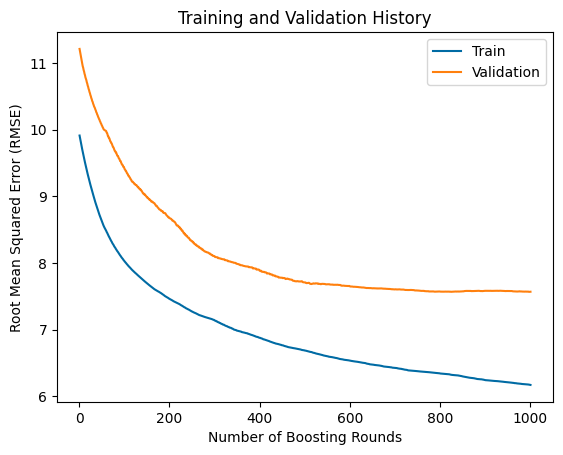

In [116]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

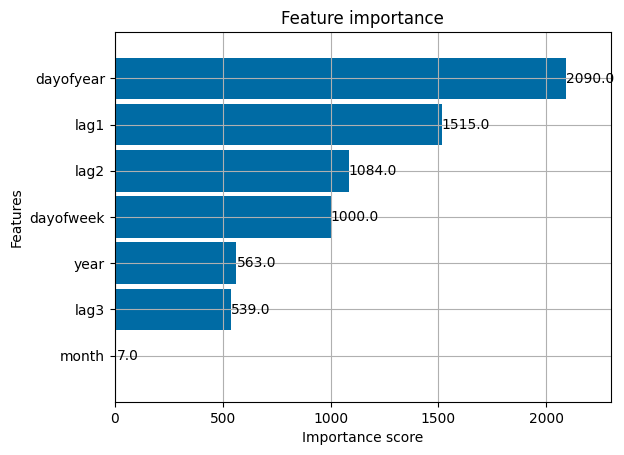

In [117]:
_ = plot_importance(reg, height=0.9)

In [118]:
y_pred = reg.predict(X_val)

In [119]:
y_pred

array([31.672134 , 31.92372  , 24.661922 , 14.929623 , 31.911171 ,
       32.312225 , 34.75364  , 31.895859 , 32.438076 , 24.388754 ,
       17.974316 , 31.25668  , 31.116299 , 31.719484 , 31.659716 ,
       31.772085 , 20.553198 , 19.332201 , 31.071383 , 32.292984 ,
       30.523264 , 33.00002  , 32.239655 , 19.90751  , 19.305956 ,
       29.823807 , 30.890888 , 31.57996  , 31.633322 , 31.894701 ,
       24.095047 , 18.24592  , 31.161789 , 31.121794 , 32.39227  ,
       31.746933 , 31.767645 , 24.23251  , 15.469797 , 31.051857 ,
       30.87434  , 32.397186 , 31.49189  , 34.87072  , 24.108192 ,
       17.069826 , 31.37758  , 31.059227 , 31.902851 , 31.55214  ,
       33.84128  , 20.555191 , 17.996067 , 30.411999 , 32.005554 ,
       33.72912  , 32.694405 , 29.418163 , 20.595436 , 17.996067 ,
       29.55678  , 32.209858 , 30.01621  , 32.003067 , 29.088133 ,
       24.638527 , 17.410774 , 31.497196 , 31.99478  , 32.81379  ,
       32.694405 , 31.869461 , 24.1896   , 17.410774 , 31.1438

In [120]:
val['prediction'] = reg.predict(X_val)

/tmp/ipython-input-1799221841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [121]:
val['prediction']

,prediction
fecha,
2023-06-15,31.672134
2023-06-16,31.923719
2023-06-17,24.661922
2023-06-18,14.929623
2023-06-19,31.911171
...,...
2023-12-27,26.831644
2023-12-28,26.872234
2023-12-29,25.024164


In [122]:
val

,cantidad_eventos,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
fecha,,,,,,,,,,,,,
2023-06-15,44,0,3,2,6,2023,166,15,24,28.0,32.0,16.0,31.672134
2023-06-16,42,0,4,2,6,2023,167,16,24,25.0,32.0,8.0,31.923719
2023-06-17,24,0,5,2,6,2023,168,17,24,33.0,18.0,9.0,24.661922
2023-06-18,22,0,6,2,6,2023,169,18,24,20.0,24.0,6.0,14.929623
2023-06-19,16,0,0,2,6,2023,170,19,25,17.0,11.0,4.0,31.911171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,29,0,2,4,12,2023,361,27,52,21.0,21.0,22.0,26.831644
2023-12-28,25,0,3,4,12,2023,362,28,52,25.0,22.0,16.0,26.872234
2023-12-29,27,0,4,4,12,2023,363,29,52,14.0,19.0,10.0,25.024164


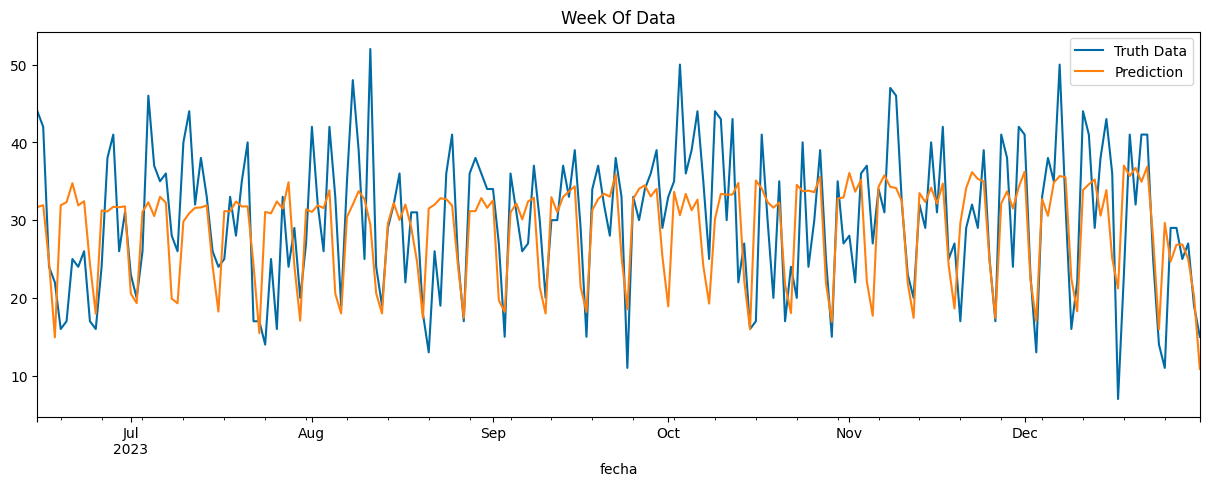

In [123]:
ax = val.loc[(val.index >= '2017-08-03')]['cantidad_eventos'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [124]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [125]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 57.30341720581055
Mean Absolute Error (MAE): 5.988396644592285
RMSE Score on Test set: 7.57


In [126]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.9 MB/s eta 0:00:00


In [127]:
import optuna

[I 2025-10-02 16:30:17,256] A new study created in memory with name: no-name-f895eb8b-719a-4d5c-9e7e-9021ac9671f8
[I 2025-10-02 16:30:25,519] Trial 0 finished with value: 7.472651627368937 and parameters: {'n_estimators': 768, 'max_depth': 10, 'learning_rate': 0.051819211080095635, 'subsample': 0.6624720918207189, 'colsample_bytree': 0.6559149282449962, 'reg_alpha': 0.00032065274964761513, 'reg_lambda': 2.9045590500027185e-08}. Best is trial 0 with value: 7.472651627368937.
[I 2025-10-02 16:30:26,513] Trial 1 finished with value: 7.460827214907992 and parameters: {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.032514968393904296, 'subsample': 0.9270506479634666, 'colsample_bytree': 0.9265607971625178, 'reg_alpha': 1.1034741088377272e-06, 'reg_lambda': 0.4300975728907606}. Best is trial 1 with value: 7.460827214907992.
[I 2025-10-02 16:30:31,807] Trial 2 finished with value: 7.7357479324697405 and parameters: {'n_estimators': 465, 'max_depth': 6, 'learning_rate': 0.091537519064

Best hyperparameters:  {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.032514968393904296, 'subsample': 0.9270506479634666, 'colsample_bytree': 0.9265607971625178, 'reg_alpha': 1.1034741088377272e-06, 'reg_lambda': 0.4300975728907606}
Best RMSE:  7.460827214907992


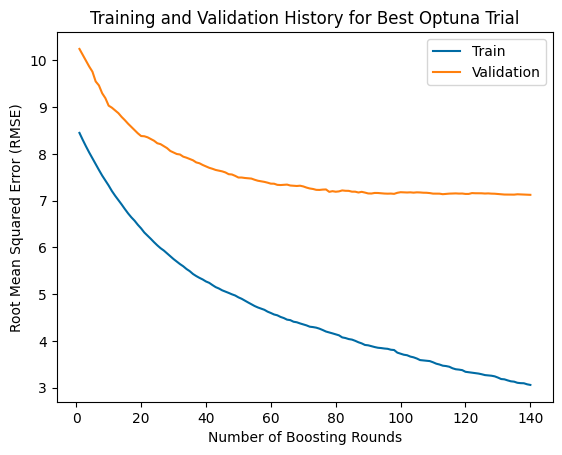

In [130]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_siniestros_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = 'cantidad_eventos'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

## Entrenamiento del modelo final

Entrenar el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna en el conjunto de datos completo de entrenamiento.

In [135]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'cantidad_eventos'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_siniestros_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9265607971625178, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.032514968393904296,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=-1,
             num_parallel_tree=None, ...)

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 8.07
Final Model MAE on Test Set: 6.40


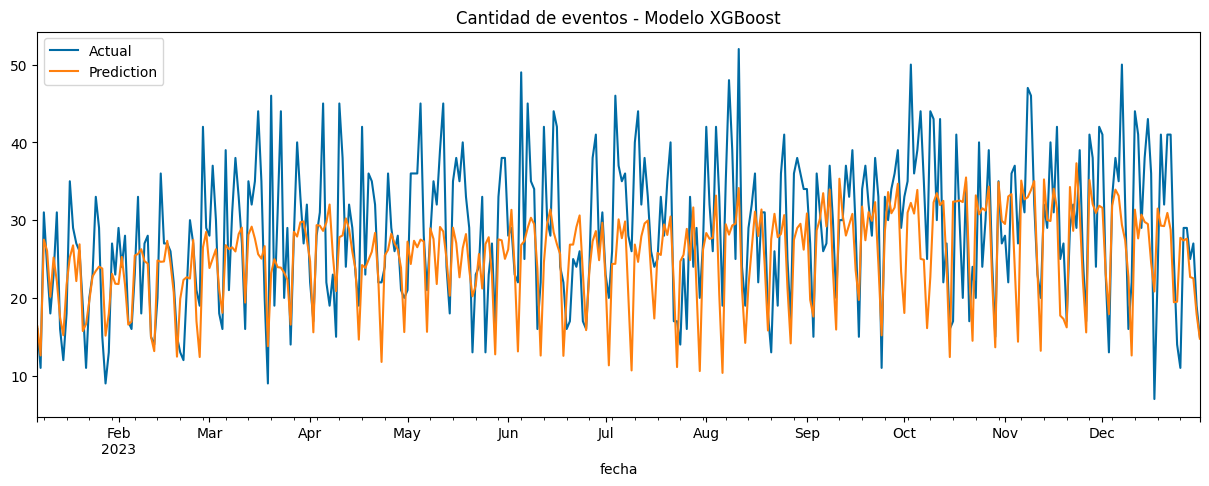

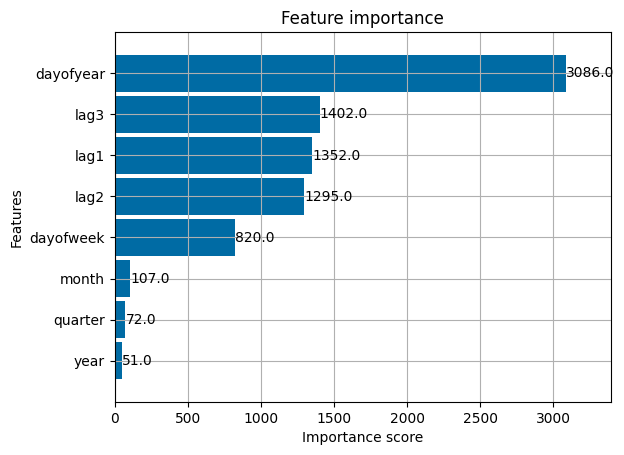

In [137]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Cantidad de eventos - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

# Precipitaciones

In [15]:
df_precipitaciones.rename(columns={'Unnamed: 0': 'fecha'}, inplace=True)
df_precipitaciones.head()

,fecha,(mm)
0,2019-01-01,2.0
1,2019-01-02,9.0
2,2019-01-03,0.0
3,2019-01-04,0.0
4,2019-01-05,1.0


# Temperatura

In [17]:
df_temperatura.rename(columns={'Unnamed: 0': 'fecha', '(°C)': 'Maxima', 'Unnamed: 2': 'Minima'}, inplace=True)
df_temperatura.head()

,fecha,Maxima,Minima
0,2019-01-01,32.7,23.4
1,2019-01-02,32.1,23.7
2,2019-01-03,26.3,17
3,2019-01-04,28.9,18
4,2019-01-05,30.1,21.2
